In [ ]:
# 코드 실행 후 런타임 재시작

# 한글 시각화
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 분류모델에서 필요한 패키지
!pip install category_encoders 
!pip install xgboost==1.7.2
!pip3 install imbalanced-learn
!pip install eli5
!pip install scikit-learn==1.1.3

In [1]:
# 라이브러리 불러오기
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from scipy import stats
from xgboost import *
from sklearn.tree import *
from sklearn.metrics import *
from sklearn.preprocessing import *
from sklearn.linear_model import *
from sklearn.model_selection import *
from sklearn.ensemble import *
from sklearn.pipeline import *
from sklearn.impute import *
from eli5.sklearn import *
from sklearn.tree import *
from xgboost import *
from category_encoders import *

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

import warnings
warnings.filterwarnings(action='ignore')

plt.rc('font', family='NanumGothic')
%config InlineBackend.figure_format='retina'

In [2]:
# 구글 드라이브 연동
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 데이터 불러오기
player_info = pd.read_csv('/content/drive/MyDrive/Codestates/N200/Project/data/player_info.csv')
ranker_player = pd.read_csv('/content/drive/MyDrive/Codestates/N200/Project/data/ranker_player.csv')

# 타겟 변수 추출
- 랭커들이 많이 사용하는 선수번호 추출

In [4]:
# 랭커들의 선수 기록 데이터를 각 선수의 사용 횟수로 정렬
ranker_use = ranker_player.groupby('spId')['matchCount'].sum().reset_index(drop=False)
ranker_use.sort_values('matchCount', ascending=False, inplace=True)
ranker_use.reset_index(drop=True, inplace=True)
ranker_use

,spId,matchCount
0,279238074,534
1,279181458,434
2,225242881,423
3,234191208,411
4,247199266,404
...,...,...
34822,319238449,1
34823,319238343,1
34824,319237697,1
34825,319237324,1


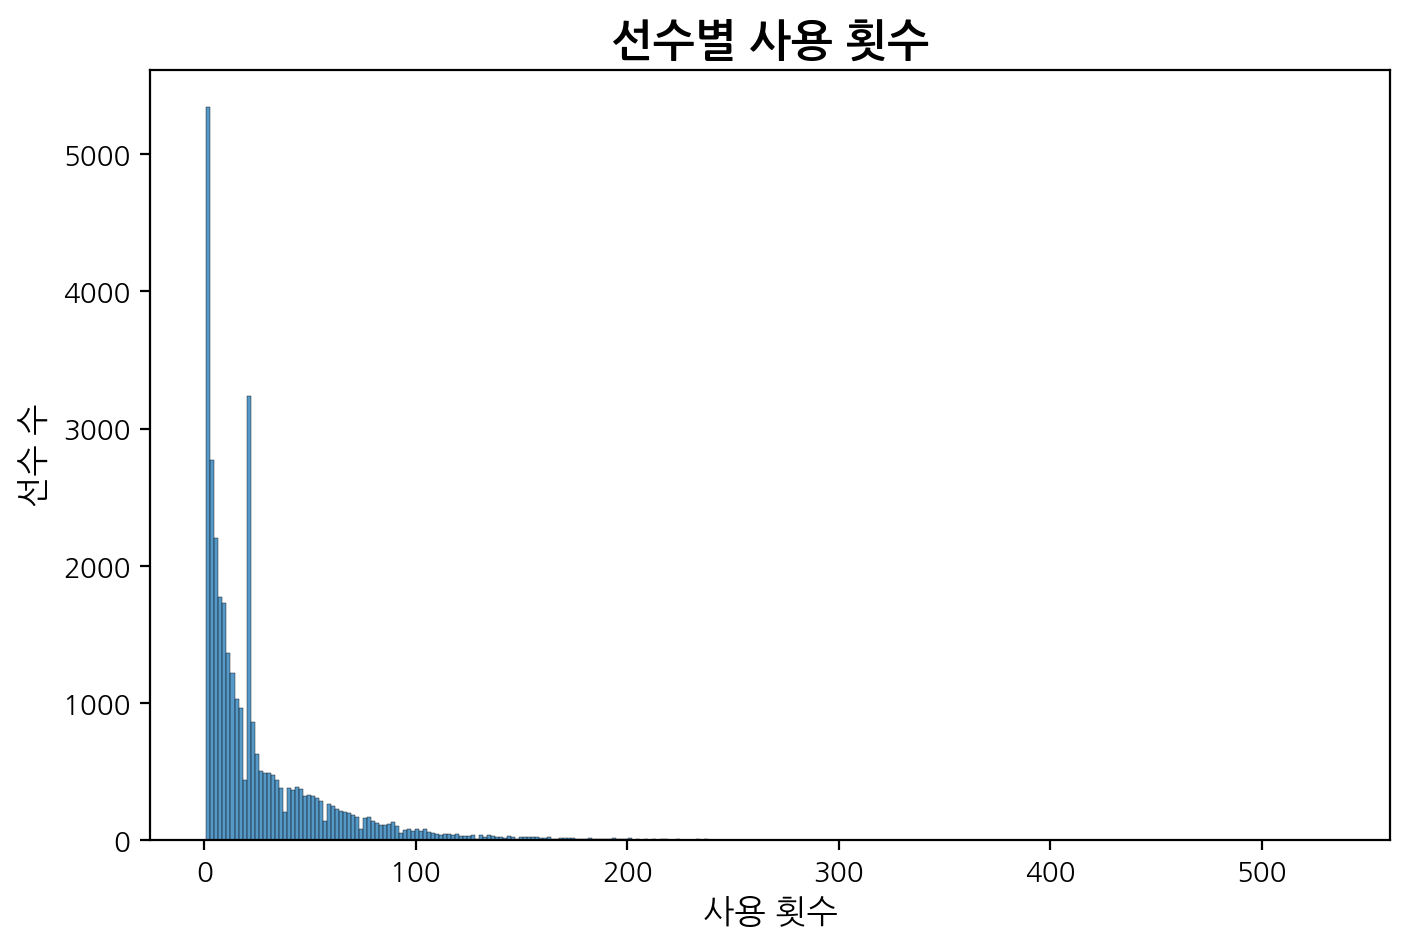

In [8]:
# 시각화
plt.figure(figsize=(8,5))

sns.histplot(data=ranker_use,
             x='matchCount')
plt.title('선수별 사용 횟수', fontsize=16, fontweight = 'bold')
plt.ylabel('선수 수', fontsize=12)
plt.xlabel('사용 횟수', fontsize=12)
plt.show()

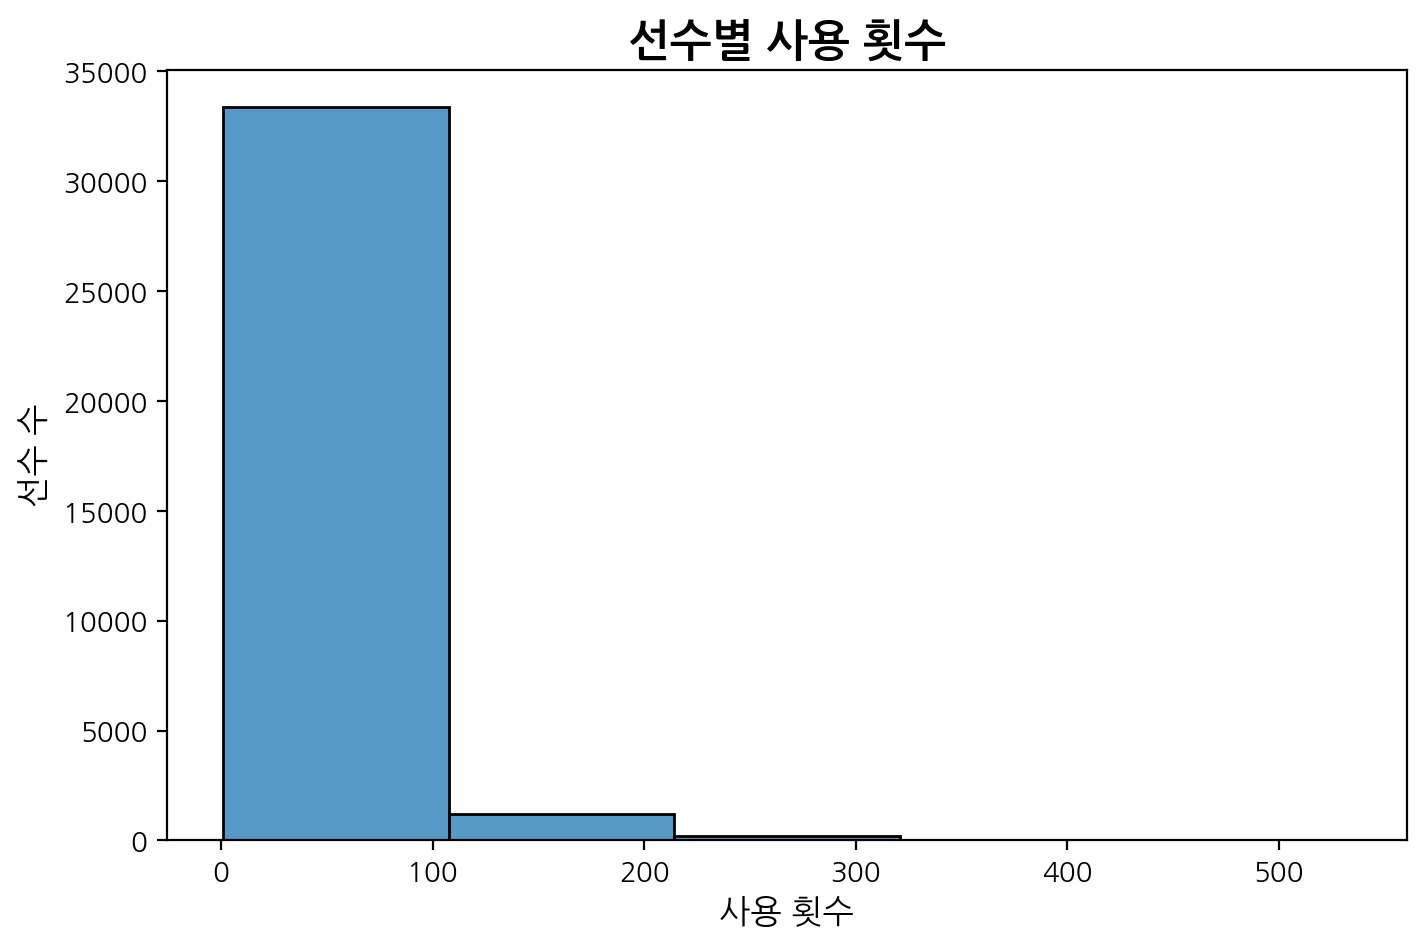

In [9]:
# 100단위로 나누어 시각화
plt.figure(figsize=(8,5))

sns.histplot(data=ranker_use,
             x='matchCount',
             bins = 5)
plt.title('선수별 사용 횟수', fontsize=16, fontweight = 'bold')
plt.ylabel('선수 수', fontsize=12)
plt.xlabel('사용 횟수', fontsize=12)
plt.show()

In [15]:
# 100회 이상 사용한 선수에 대해서 라벨링
ranker_use['Over 100'] = np.nan
for i in range(len(ranker_use)) :
  if ranker_use.loc[i,'matchCount'] >= 100 :
    ranker_use.loc[i,'Over 100'] = 1
  else :
    ranker_use.loc[i,'Over 100'] = 0

In [16]:
ranker_use['Over 100'] = ranker_use['Over 100'].astype('int')
ranker_use

,spId,matchCount,Over 100
0,279238074,534,1
1,279181458,434,1
2,225242881,423,1
3,234191208,411,1
4,247199266,404,1
...,...,...,...
34822,319238449,1,0
34823,319238343,1,0
34824,319237697,1,0
34825,319237324,1,0


In [17]:
ranker_use['Over 100'] = ranker_use['Over 100'].replace({0 : '미사용', 1 : '사용'})

In [24]:
y.value_counts().index

Index(['미사용', '사용'], dtype='object')

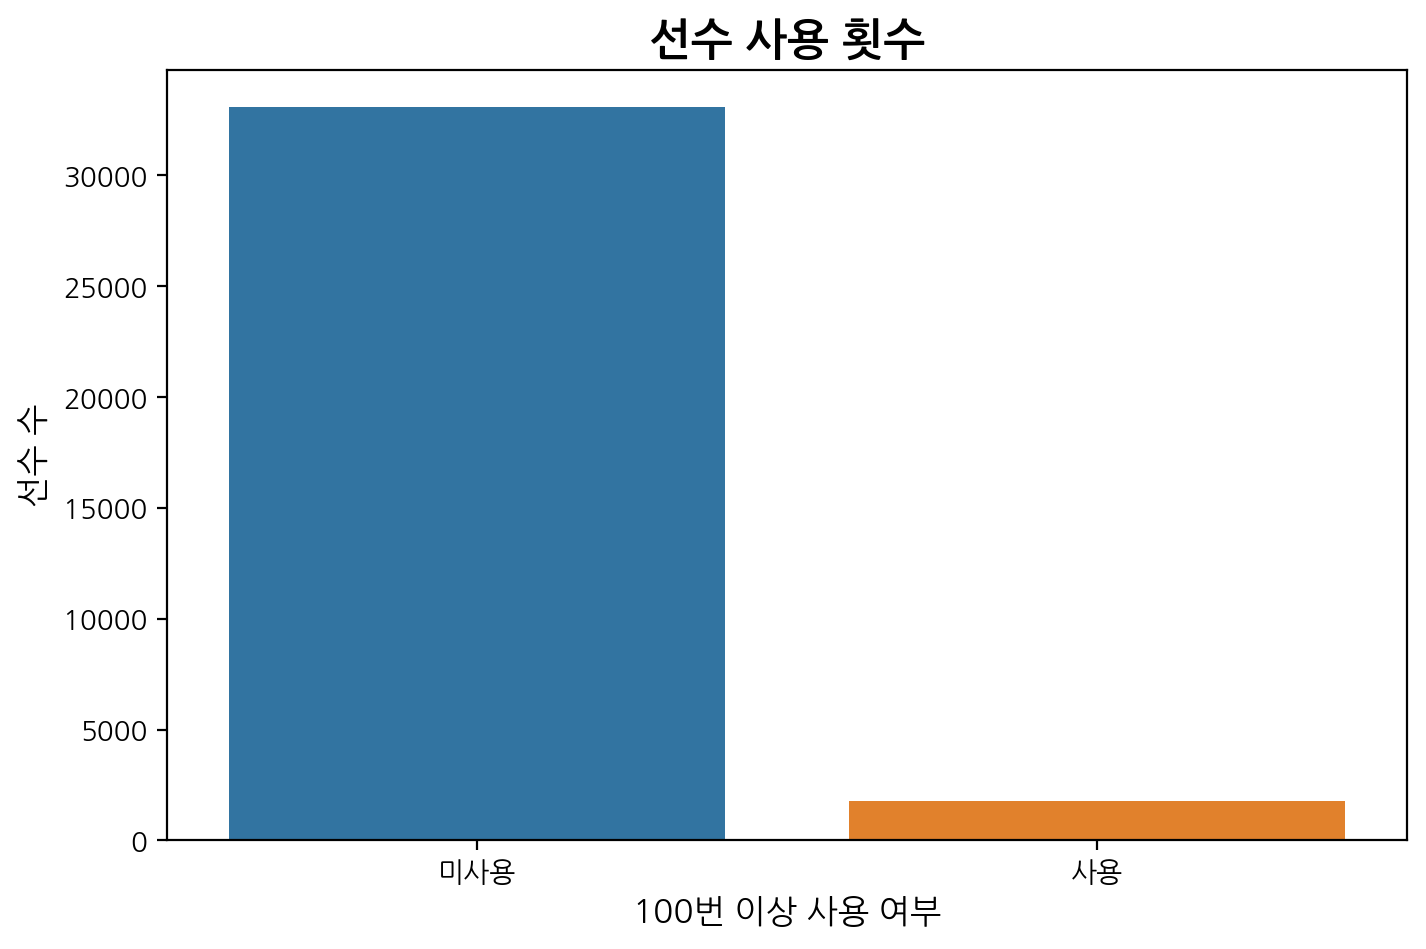

In [25]:
# Over 100 칼럼 기준으로 그룹을 나누어 시각화
plt.figure(figsize=(8,5))

y =  ranker_use['Over 100']

sns.countplot(x=y, order = y.value_counts().index)
plt.title('선수 사용 횟수', fontsize=16, fontweight = 'bold')
plt.ylabel('선수 수', fontsize=12)
plt.xlabel('100번 이상 사용 여부', fontsize=12)
plt.show()

In [31]:
# 100회 이상 사용 선수의 선수고유번호 저장
frequent_player = []
for i in range(len(ranker_use)) :
  player_id = ranker_use.loc[i,'spId']
  if ranker_use.loc[i,'Over 100'] == '사용' :
    frequent_player.append(player_id)

In [32]:
# 잘 저장되었는지 확인
ranker_use['Over 100'].value_counts()[1] == len(frequent_player)

True

# 데이터 전처리

## 타겟 변수 추가

In [33]:
player_info['OP 여부'] = np.nan
for i in range(len(player_info)) :
  if player_info.loc[i,'선수고유번호'] in frequent_player :
    player_info.loc[i,'OP 여부'] = 1
  else :
    player_info.loc[i,'OP 여부'] = 0

In [34]:
player_info['OP 여부'].value_counts()

0.0    59420
1.0     1761
Name: OP 여부, dtype: int64

In [35]:
player_info.head()

,선수고유번호,선수이름,포지션,신장,몸무게,총 능력치,속력,가속력,골 결정력,슛 파워,...,점프,침착성,GK 다이빙,GK 핸들링,GK 킥,GK 반응속도,GK 위치 선정,평가점수,급여,OP 여부
0,101000001,데이비드 시먼,GK,193cm,93kg,104.0,57.0,73.0,51.0,48.0,...,80.0,89.0,101.0,108.0,109.0,104.0,106.0,5.5,20.0,0.0
1,101000051,앨런 시어러,ST,182cm,78kg,110.0,105.0,106.0,117.0,115.0,...,107.0,116.0,26.0,24.0,28.0,22.0,24.0,9.0,25.0,1.0
2,101000195,로비 파울러,ST,175cm,72kg,104.0,104.0,107.0,107.0,107.0,...,100.0,104.0,18.0,22.0,19.0,21.0,21.0,7.5,23.0,0.0
3,101000240,로이 킨,CDM,180cm,76kg,108.0,98.0,96.0,95.0,92.0,...,92.0,103.0,25.0,28.0,20.0,20.0,22.0,0.0,24.0,0.0
4,101000241,라이언 긱스,LM,179cm,71kg,109.0,115.0,114.0,103.0,103.0,...,100.0,113.0,26.0,27.0,27.0,29.0,28.0,0.0,24.0,0.0


## 데이터 타입 변경

In [36]:
player_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61181 entries, 0 to 61180
Data columns (total 43 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   선수고유번호    61181 non-null  int64  
 1   선수이름      61181 non-null  object 
 2   포지션       61181 non-null  object 
 3   신장        61181 non-null  object 
 4   몸무게       61181 non-null  object 
 5   총 능력치     61181 non-null  float64
 6   속력        61181 non-null  float64
 7   가속력       61181 non-null  float64
 8   골 결정력     61181 non-null  float64
 9   슛 파워      61181 non-null  float64
 10  중거리 슛     61181 non-null  float64
 11  위치 선정     61181 non-null  float64
 12  발리슛       61181 non-null  float64
 13  패널티 킥     61181 non-null  float64
 14  짧은 패스     61181 non-null  float64
 15  시야        61181 non-null  float64
 16  크로스       61181 non-null  float64
 17  긴 패스      61181 non-null  float64
 18  프리킥       61181 non-null  float64
 19  커브        61181 non-null  float64
 20  드리블       61181 non-null  fl

In [37]:
# 선수고유번호는 문자형으로 변경
player_info['선수고유번호'] = player_info['선수고유번호'].astype('str')

In [38]:
# 스텟 관련 칼럼들을 정수형 타입으로 변경
stat_cols = list(player_info.dtypes[player_info.dtypes == 'float'].index)
stat_cols.remove('평가점수')

for stat in stat_cols :
  player_info[stat] = player_info[stat].astype('int')

In [39]:
# 신장, 몸무게 칼럼의 단위 표시 제거 및 수치형으로 변경
player_info['신장'] = player_info['신장'].str.replace('[a-zA-Z]','')
player_info['신장'] = player_info['신장'].astype('int')
player_info['몸무게'] = player_info['몸무게'].str.replace('[a-zA-Z]','')
player_info['몸무게'] = player_info['몸무게'].astype('int')

In [40]:
# 변경 확인
player_info.head()

,선수고유번호,선수이름,포지션,신장,몸무게,총 능력치,속력,가속력,골 결정력,슛 파워,...,점프,침착성,GK 다이빙,GK 핸들링,GK 킥,GK 반응속도,GK 위치 선정,평가점수,급여,OP 여부
0,101000001,데이비드 시먼,GK,193,93,104,57,73,51,48,...,80,89,101,108,109,104,106,5.5,20,0
1,101000051,앨런 시어러,ST,182,78,110,105,106,117,115,...,107,116,26,24,28,22,24,9.0,25,1
2,101000195,로비 파울러,ST,175,72,104,104,107,107,107,...,100,104,18,22,19,21,21,7.5,23,0
3,101000240,로이 킨,CDM,180,76,108,98,96,95,92,...,92,103,25,28,20,20,22,0.0,24,0
4,101000241,라이언 긱스,LM,179,71,109,115,114,103,103,...,100,113,26,27,27,29,28,0.0,24,0


In [41]:
# 변경 확인
player_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61181 entries, 0 to 61180
Data columns (total 43 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   선수고유번호    61181 non-null  object 
 1   선수이름      61181 non-null  object 
 2   포지션       61181 non-null  object 
 3   신장        61181 non-null  int64  
 4   몸무게       61181 non-null  int64  
 5   총 능력치     61181 non-null  int64  
 6   속력        61181 non-null  int64  
 7   가속력       61181 non-null  int64  
 8   골 결정력     61181 non-null  int64  
 9   슛 파워      61181 non-null  int64  
 10  중거리 슛     61181 non-null  int64  
 11  위치 선정     61181 non-null  int64  
 12  발리슛       61181 non-null  int64  
 13  패널티 킥     61181 non-null  int64  
 14  짧은 패스     61181 non-null  int64  
 15  시야        61181 non-null  int64  
 16  크로스       61181 non-null  int64  
 17  긴 패스      61181 non-null  int64  
 18  프리킥       61181 non-null  int64  
 19  커브        61181 non-null  int64  
 20  드리블       61181 non-null  in

## 이상치 탐색
- 데이터 크롤링 과정에서 잘못 글어와서 일정 범위를 크게 벗어난 수치가 없는지 탐색

In [42]:
stat_cols.remove('OP 여부')

In [43]:
len(stat_cols)

36

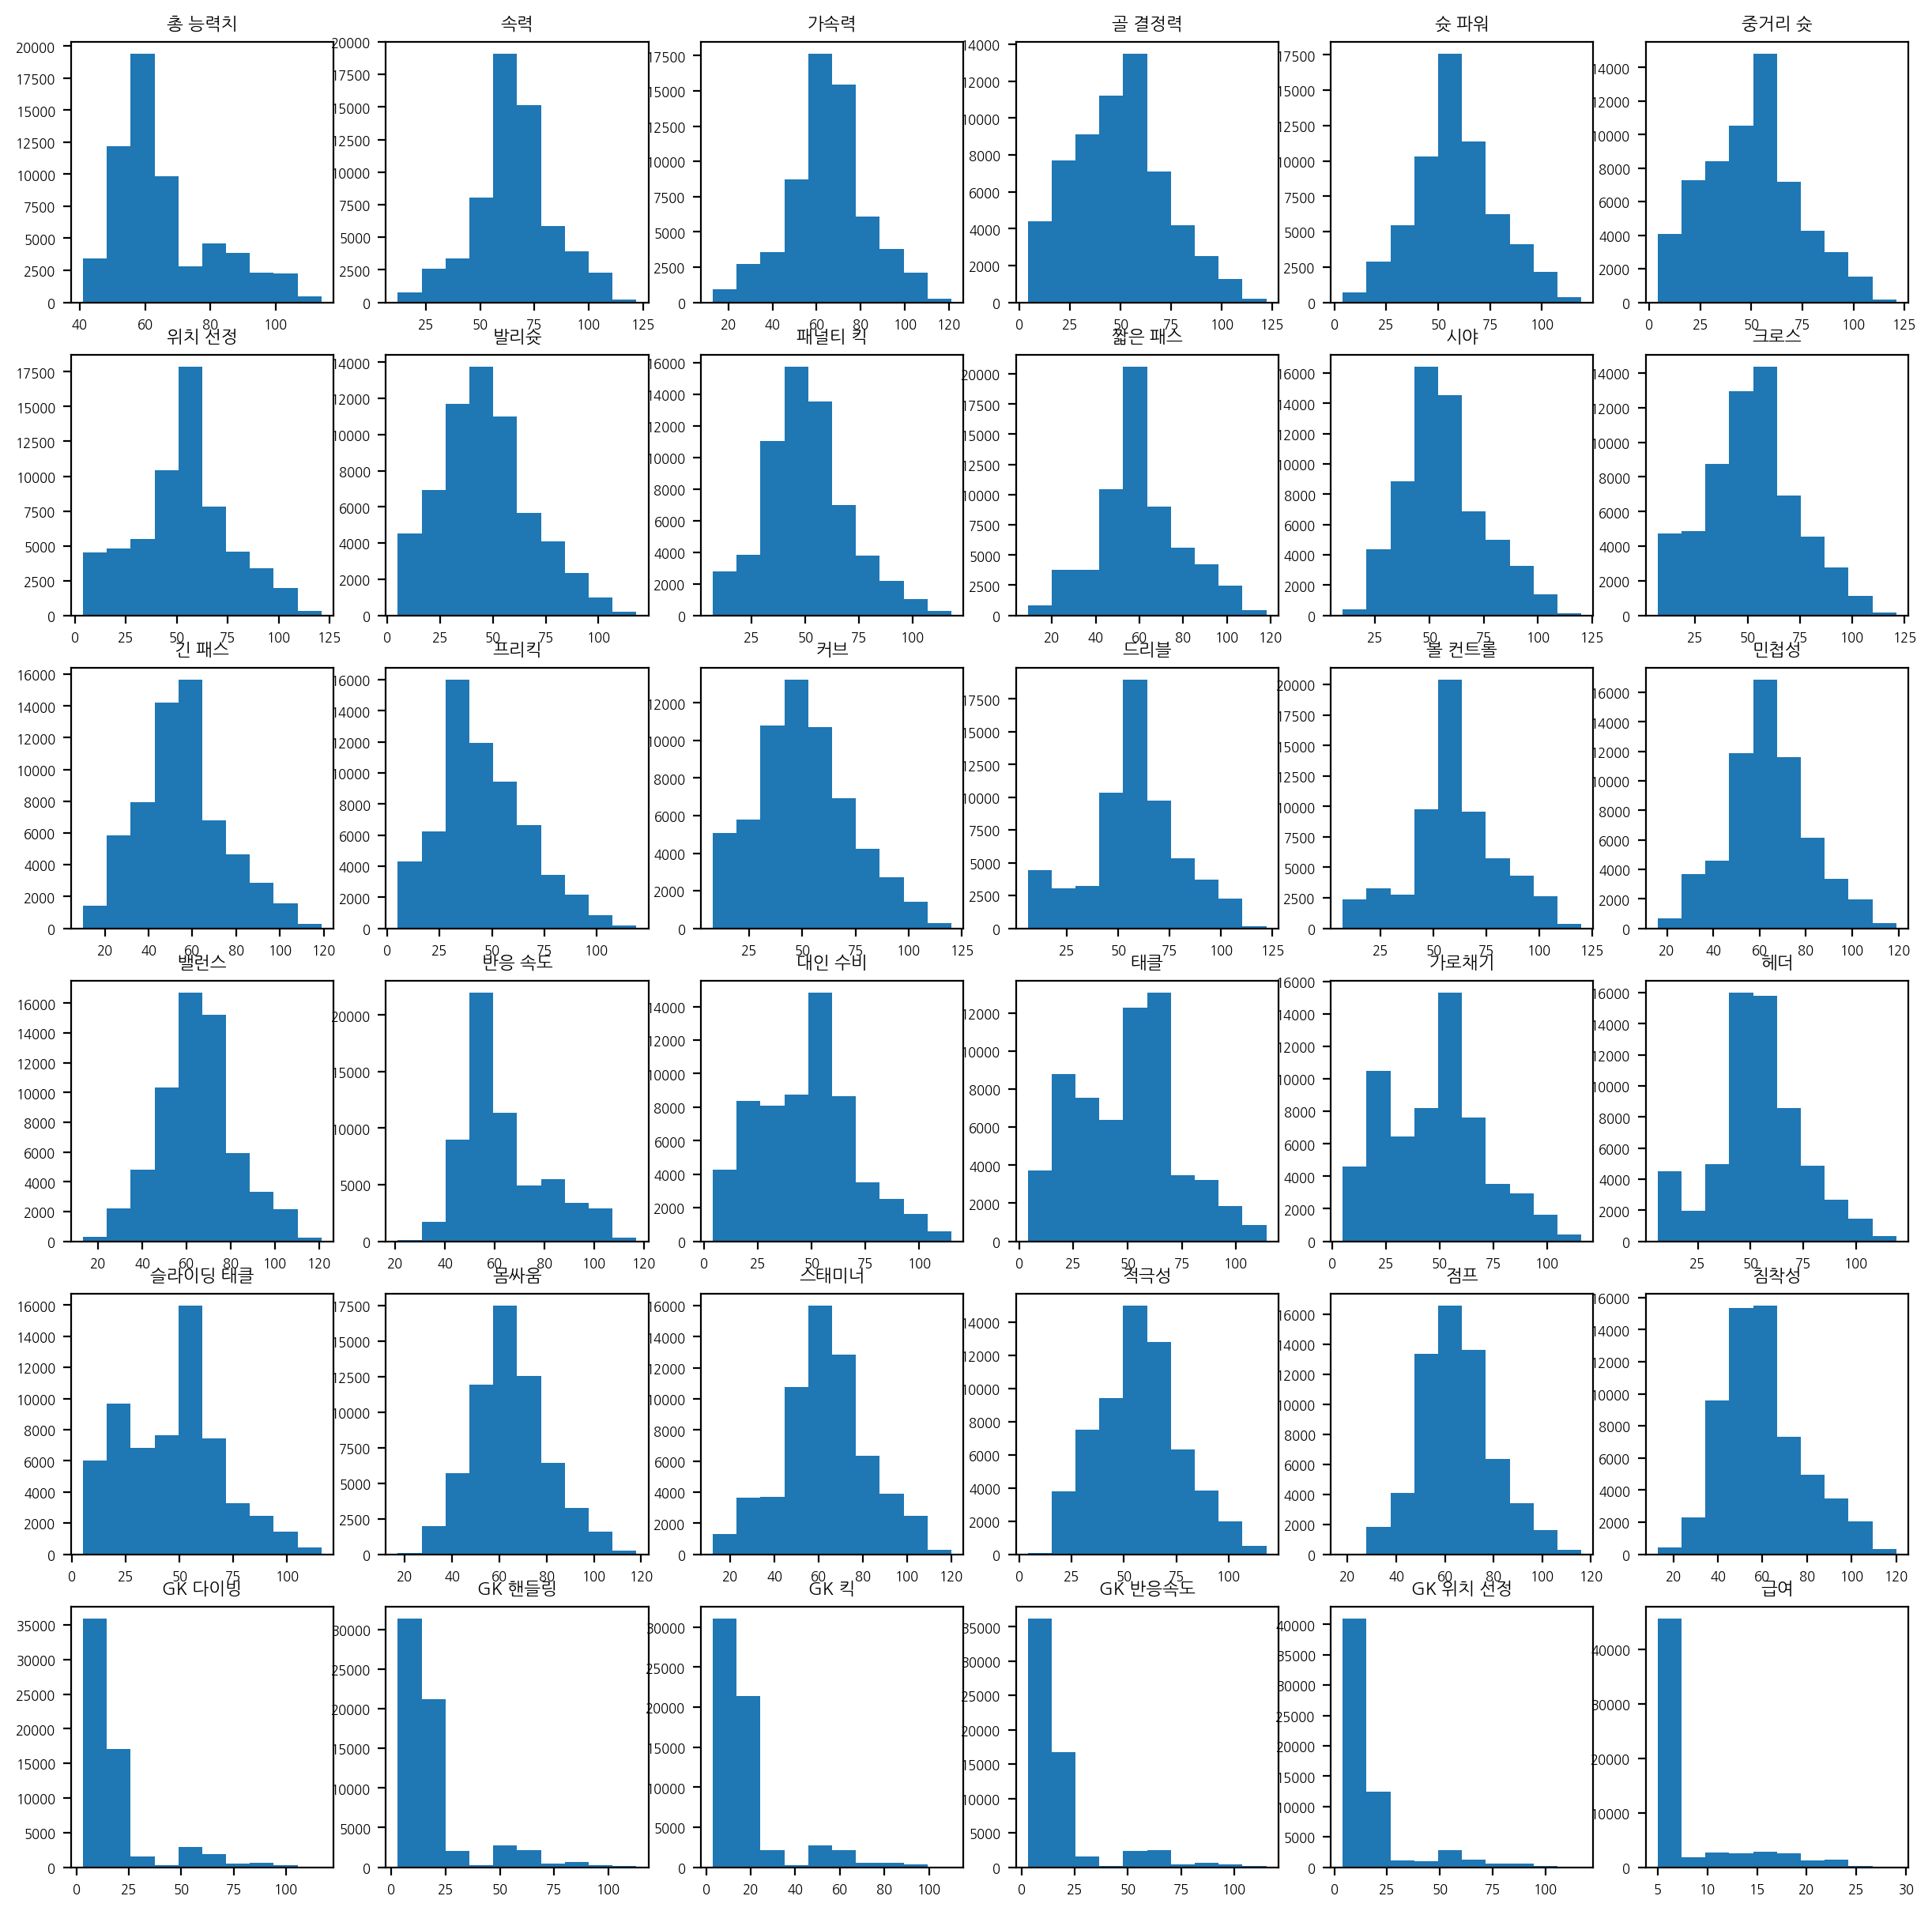

In [44]:
# 스텟 관련 칼럼
i = 0
fig, axs = plt.subplots(6,6, figsize = (15,15))

for j in range(6):
    for k in range(6):
        axs[j,k].hist(player_info[stat_cols[i]])
        axs[j,k].set_title(stat_cols[i], fontsize=8)
        axs[j,k].tick_params(axis='both', which='major', labelsize=6)  # 눈금 크기 조정
        i += 1

plt.show()

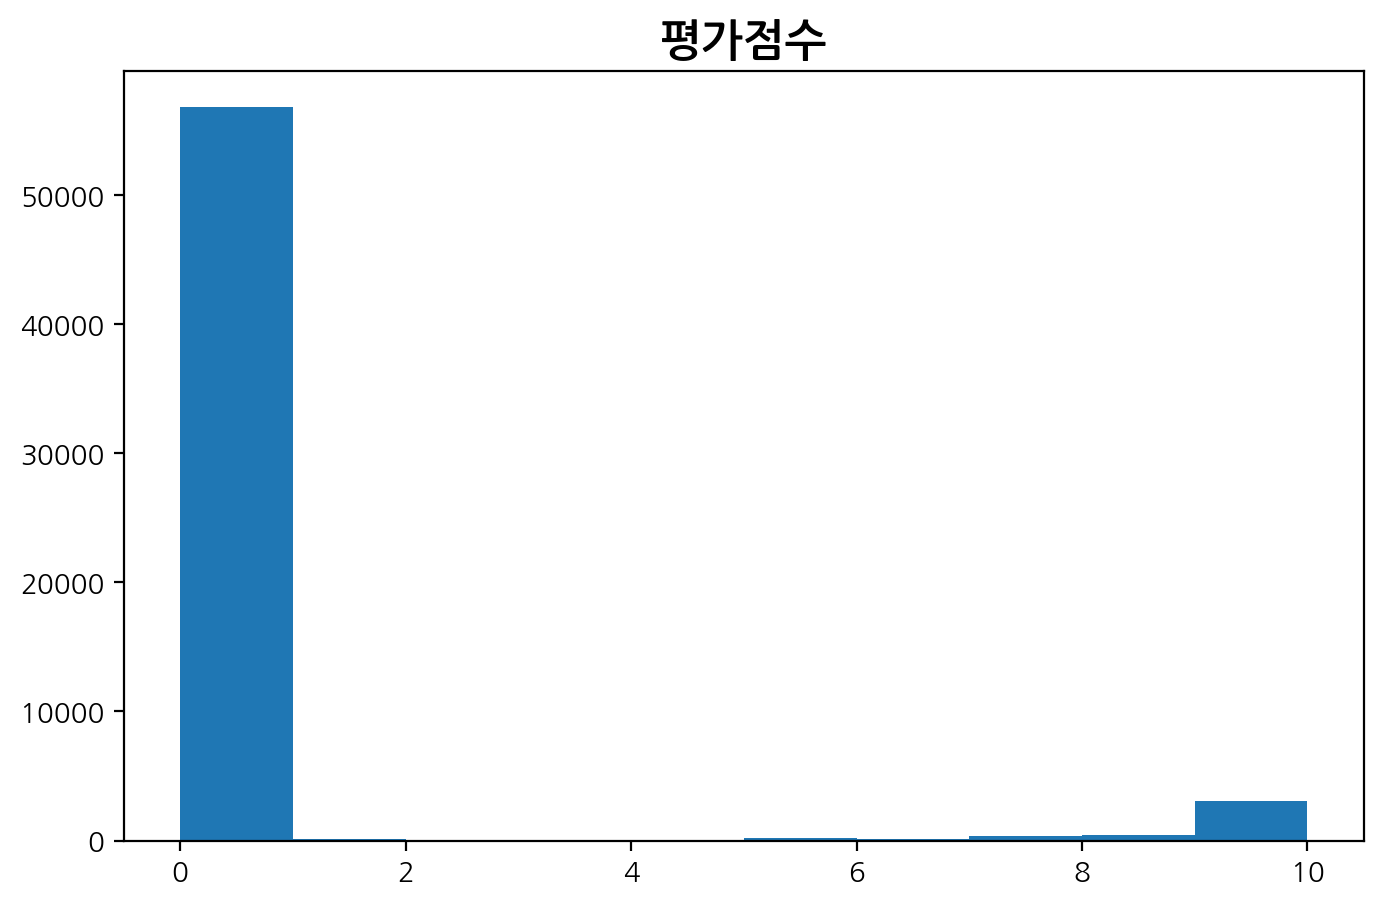

In [45]:
# 평가점수 칼럼
plt.figure(figsize=(8,5))

plt.hist(player_info['평가점수'])
plt.title('평가점수', fontsize=16, fontweight = 'bold')
plt.ylabel(None)
plt.xlabel(None)
plt.show()

- 모든 스텟 및 `평가점수` 칼럼이 정해진 범위 내에 존재함을 확인

## 칼럼 변경 및 제거

In [46]:
player_info

,선수고유번호,선수이름,포지션,신장,몸무게,총 능력치,속력,가속력,골 결정력,슛 파워,...,점프,침착성,GK 다이빙,GK 핸들링,GK 킥,GK 반응속도,GK 위치 선정,평가점수,급여,OP 여부
0,101000001,데이비드 시먼,GK,193,93,104,57,73,51,48,...,80,89,101,108,109,104,106,5.5,20,0
1,101000051,앨런 시어러,ST,182,78,110,105,106,117,115,...,107,116,26,24,28,22,24,9.0,25,1
2,101000195,로비 파울러,ST,175,72,104,104,107,107,107,...,100,104,18,22,19,21,21,7.5,23,0
3,101000240,로이 킨,CDM,180,76,108,98,96,95,92,...,92,103,25,28,20,20,22,0.0,24,0
4,101000241,라이언 긱스,LM,179,71,109,115,114,103,103,...,100,113,26,27,27,29,28,0.0,24,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61176,511257540,A. 크나우프,RM,180,73,83,95,96,74,74,...,74,75,25,29,29,24,30,0.0,13,0
61177,511257889,K. 야키치,CDM,181,75,84,66,85,64,88,...,75,80,26,26,22,26,26,0.0,14,0
61178,511259307,M. 구스토,RB,179,74,82,95,92,57,71,...,78,82,26,23,30,27,25,0.0,12,0
61179,511262621,G. 마마르다슈빌리,GK,199,88,85,60,60,26,67,...,65,41,88,87,83,88,89,9.5,12,0


In [47]:
# 포지션 칼럼의 카디널리티가 너무 많이 존재
player_info['포지션'].nunique()

17

In [48]:
# 현재 나뉘어진 17가지 칼럼을 4가지 칼럼으로 변경
striker = ['LS','ST','RS','LF','CF','RF','LW','RW']
midfielder = ['LAM','CAM','RAM','LM','RM','LCM','CM','RCM','LDM','CDM','RDM']
defender = ['LWB','RWB','LB','RB','LCB','CB','RCB','SW']
goalkeeper = ['GK']

for i in range(len(player_info)) : 
  if player_info.loc[i,'포지션'] in striker :
    player_info.loc[i,'포지션'] = '공격수'
  elif player_info.loc[i,'포지션'] in midfielder :
    player_info.loc[i,'포지션'] = '미드필더'
  elif player_info.loc[i,'포지션'] in defender :
    player_info.loc[i,'포지션'] = '수비수'
  elif player_info.loc[i,'포지션'] in goalkeeper :
    player_info.loc[i,'포지션'] = '골키퍼'
  else :
    print('에러')

In [49]:
player_info['포지션'].nunique()

4

In [50]:
# 다른 스텟 정보를 바탕으로 산출 가능한 총 능력치 칼럼 제거
player_info.drop('총 능력치', axis=1, inplace=True)

# OP 선수 시각화

In [51]:
# 포지션 별로 중요한 스텟이 다르기 때문에, 포지션 별로 다른 분류 모델을 생성할 예정
# 따라서 데이터를 포지션 기준으로 나누기 위해 시각화하여 우선 확인
op = player_info[player_info['OP 여부'] == 1]

In [52]:
op['포지션'].value_counts()

미드필더    739
공격수     564
수비수     458
Name: 포지션, dtype: int64

In [56]:
op_pie = op['포지션'].value_counts().reset_index(drop=False)
op_pie.columns = ['포지션','Count']

In [60]:
op_pie['Color'] = ['#90EE90','#FF4500','#00BFFF']

In [61]:
op_pie

,포지션,Count,Color
0,미드필더,739,#90EE90
1,공격수,564,#FF4500
2,수비수,458,#00BFFF


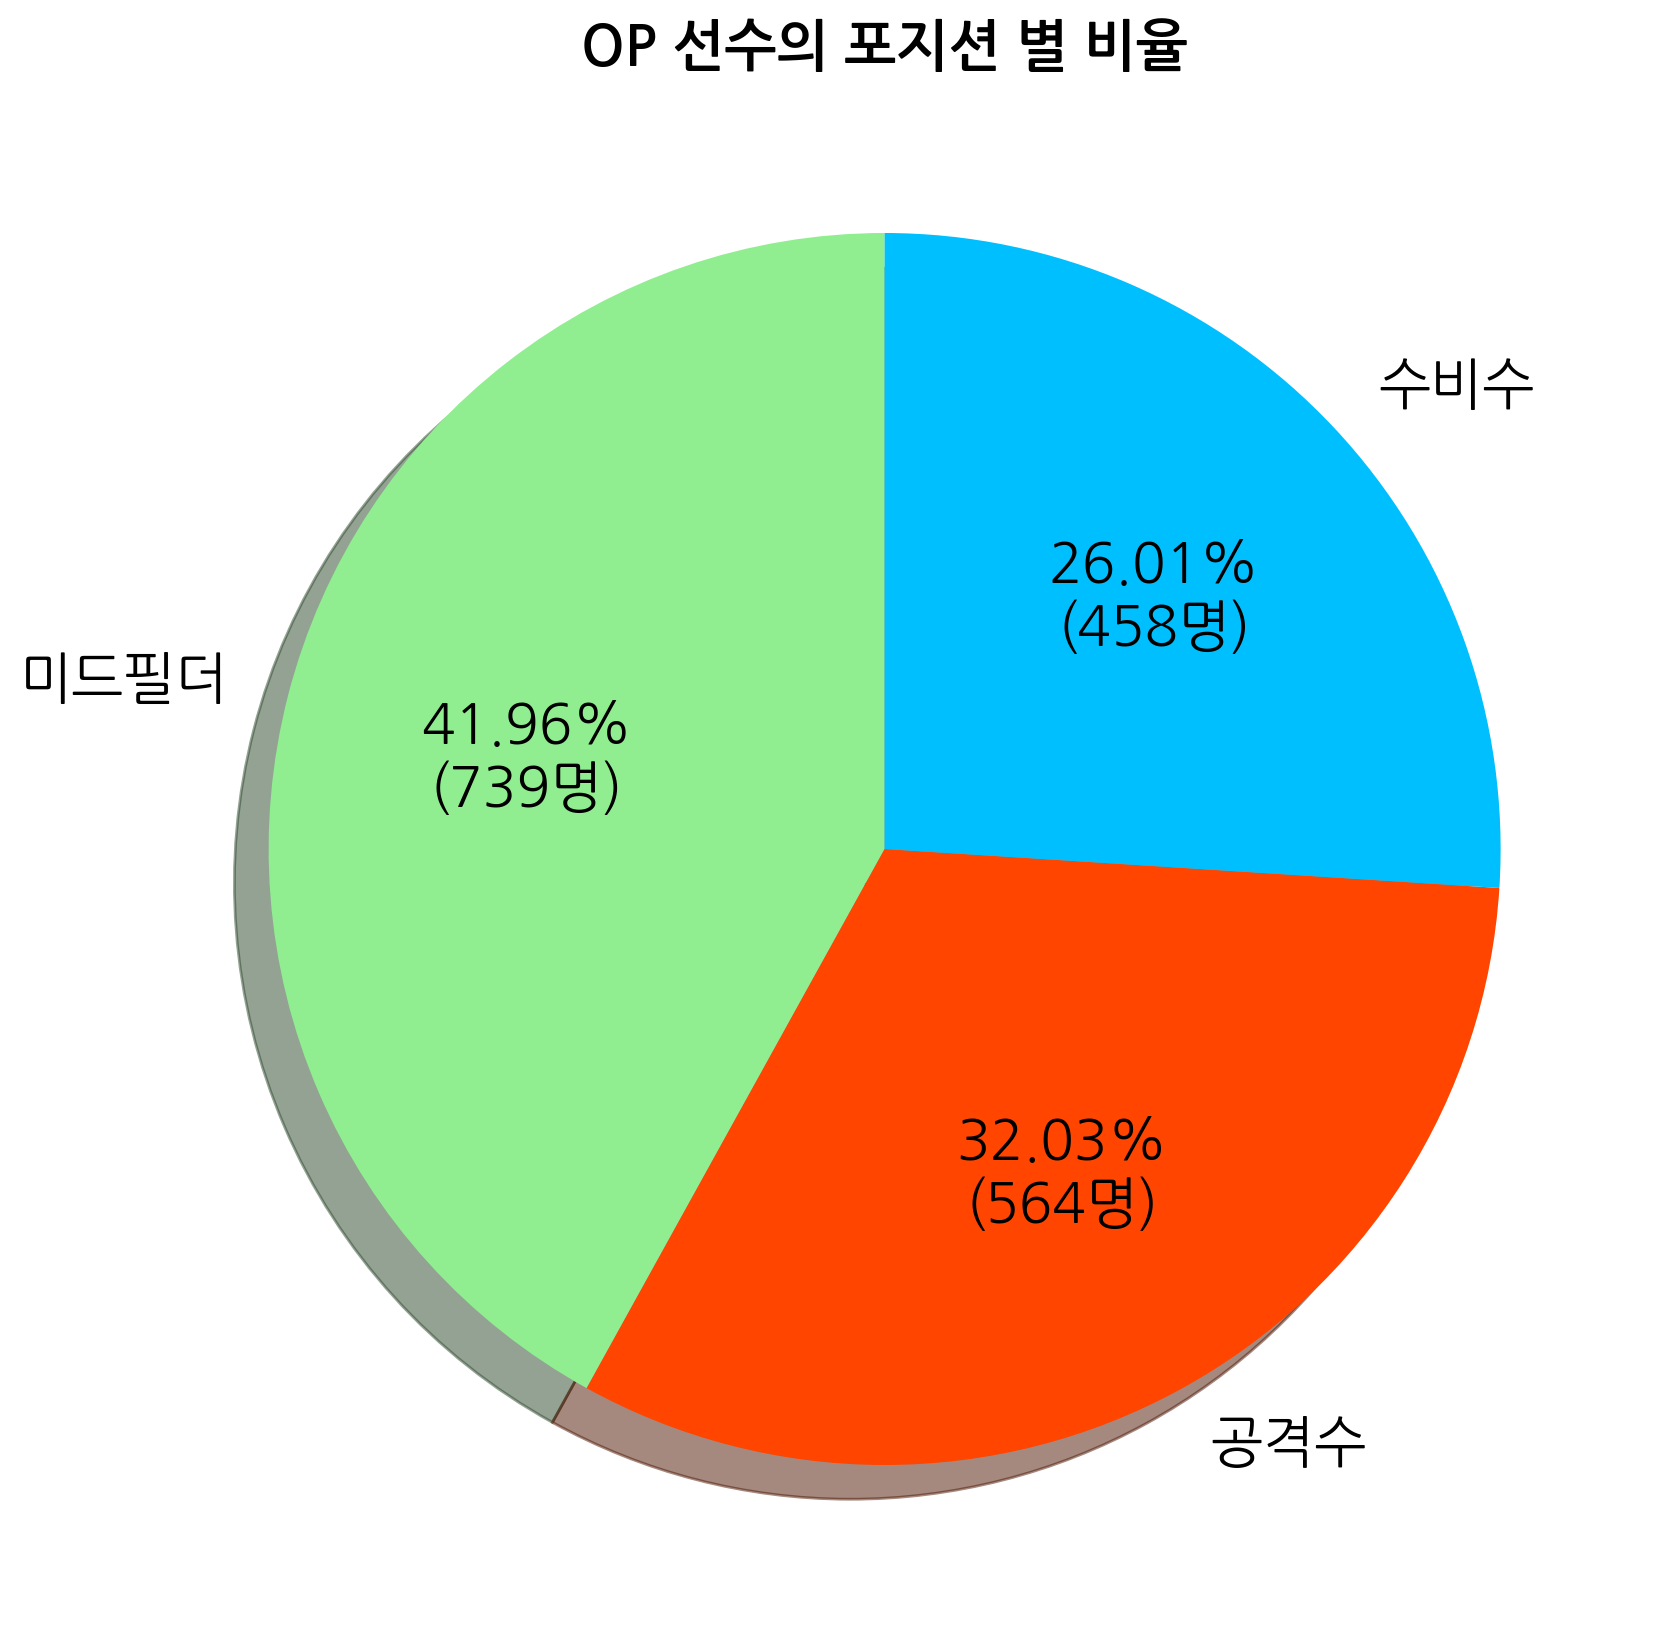

In [63]:
def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return f"{pct:.2f}%\n({absolute:d}명)"

plt.figure(figsize=(15,10))

ratio = list(op_pie['Count'])
labels = list(op_pie['포지션'])
plt.pie(ratio, labels=labels, 
        autopct = lambda pct: func(pct, list(op_pie['Count'])),
        colors = op_pie['Color'],
        shadow=True,
        startangle=90,
        textprops = {'fontsize' : 20})
plt.title('OP 선수의 포지션 별 비율', fontsize=20, fontweight='bold')

plt.show()

# 데이터 저장

In [64]:
# 포지션 별 데이터 생성
attack = player_info.query('포지션 == "공격수"')
attack.drop('포지션', axis=1, inplace=True)
midfield = player_info.query('포지션 == "미드필더"')
midfield.drop('포지션', axis=1, inplace=True)
defend = player_info.query('포지션 == "수비수"')
defend.drop('포지션', axis=1, inplace=True)

In [65]:
# 저장
attack.to_csv('/content/drive/MyDrive/Codestates/N200/Project/data/attack.csv', index=False)
midfield.to_csv('/content/drive/MyDrive/Codestates/N200/Project/data/midfield.csv', index=False)
defend.to_csv('/content/drive/MyDrive/Codestates/N200/Project/data/defend.csv', index=False)